In [ ]:
# # Uncomment and run this cell if you're on Colab or Kaggle
# !git clone https://github.com/nlp-with-transformers/notebooks.git
# %cd notebooks
# from install import *
# install_requirements()

In [ ]:
# # hide
# from utils import *
# setup_chapter()

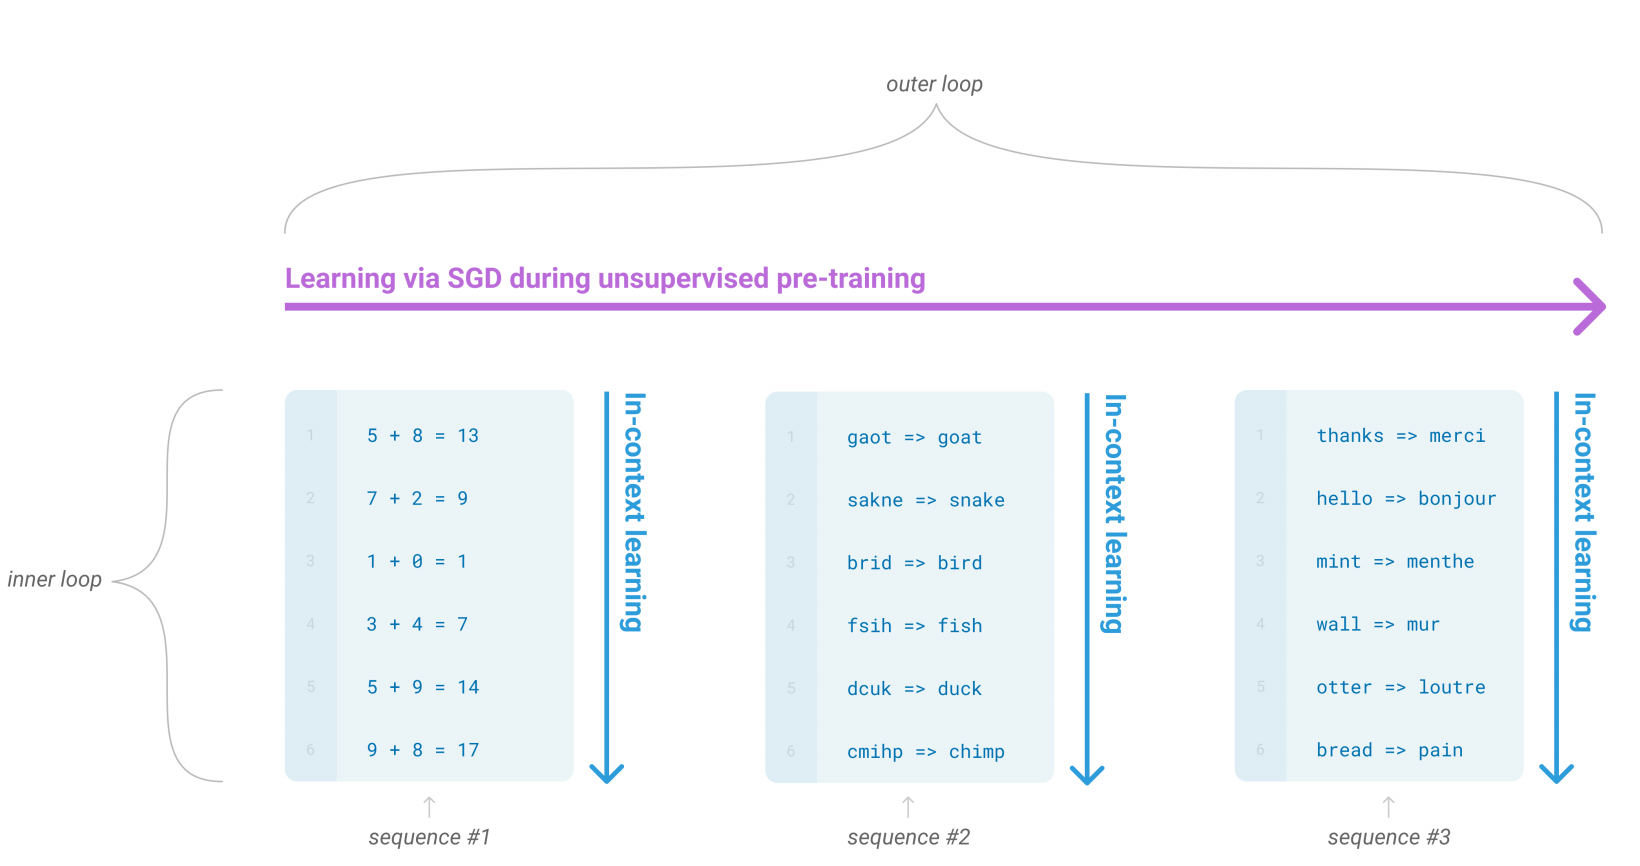

<img alt="Text generation" width="700" caption="Generating text from an input sequence by adding a new word to the input at each step" src="images/chapter05_text-generation.png" id="text-generation"/> 

## Greedy Search Decoding

In [ ]:
#@ IMPORTING MODULES: UNCOMMENT BELOW:
!pip install transformers[sentencepiece]
import torch
import pandas as pd
import numpy as np
import torch.nn.functional as F
from transformers import AutoTokenizer
from transformers import AutoModelForCausalLM

#@ IGNORING WARNINGS: 
import warnings
warnings.filterwarnings("ignore")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 75.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 102.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 79.0 MB/s eta 0:00:00


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/548M [00:00<?, ?B/s]

In [ ]:
# hide_output
import pandas as pd

input_txt = "Transformers are the"
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
iterations = []
n_steps = 8
choices_per_step = 5

with torch.no_grad():
    for _ in range(n_steps):
        iteration = dict()
        iteration["Input"] = tokenizer.decode(input_ids[0])
        output = model(input_ids=input_ids)
        # Select logits of the first batch and the last token and apply softmax
        next_token_logits = output.logits[0, -1, :]
        next_token_probs = torch.softmax(next_token_logits, dim=-1)
        sorted_ids = torch.argsort(next_token_probs, dim=-1, descending=True)
        # Store tokens with highest probabilities
        for choice_idx in range(choices_per_step):
            token_id = sorted_ids[choice_idx]
            token_prob = next_token_probs[token_id].cpu().numpy()
            token_choice = (
                f"{tokenizer.decode(token_id)} ({100 * token_prob:.2f}%)"
            )
            iteration[f"Choice {choice_idx+1}"] = token_choice
        # Append predicted next token to input
        input_ids = torch.cat([input_ids, sorted_ids[None, 0, None]], dim=-1)
        iterations.append(iteration)
        
pd.DataFrame(iterations)

,Input,Choice 1,Choice 2,Choice 3,Choice 4,Choice 5
0,Transformers are the,most (9.76%),same (2.94%),only (2.87%),best (2.38%),first (1.77%)
1,Transformers are the most,common (22.90%),powerful (6.88%),important (6.32%),popular (3.95%),commonly (2.14%)
2,Transformers are the most common,type (15.06%),types (3.31%),form (1.91%),way (1.89%),and (1.49%)
3,Transformers are the most common type,of (83.13%),in (3.16%),. (1.92%),", (1.63%)",for (0.88%)
4,Transformers are the most common type of,particle (1.55%),object (1.02%),light (0.71%),energy (0.67%),objects (0.66%)
5,Transformers are the most common type of particle,. (14.26%),in (11.57%),that (10.19%),", (9.57%)",accelerator (5.81%)
6,Transformers are the most common type of parti...,They (17.48%),\n (15.19%),The (7.06%),These (3.09%),In (3.07%)
7,Transformers are the most common type of parti...,are (38.78%),have (8.14%),can (7.98%),'re (5.04%),consist (1.57%)



    The third line tokenizes the input text and converts it to input_ids, which is a numerical representation of the input text that can be processed by the model.

    The next line defines an empty list called "iterations" which will be used to store the results of each step of the text generation.

    The code then defines two variables, n_steps and choices_per_step. n_steps determines how many steps the model will take to generate text, while choices_per_step determines how many of the top choices generated by the model will be stored in each iteration.

    Then it uses torch.no_grad() to temporarily set all the requires_grad flag to false.

    In the for loop, the code runs the model for n_steps and in each iteration, it stores the input text in iteration dictionary.

    The code then runs the model on the input_ids and stores the output in the "output" variable.

    Next, the code selects the logits of the first batch and the last token from the output and applies the softmax function to it to get the probability distribution of the next token.

    Then it sorts the token ids based on the probability in descending order.

    The code then loops through the top choices_per_step tokens and stores the token id, probability, and the token's text in iteration dictionary.

    It then appends the predicted next token to the input_ids

    Finally, it stores the iteration dictionary in the iterations list.

    After the loop, the code creates a DataFrame from the "iterations" list and display it.



In [ ]:
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output = model.generate(input_ids, max_new_tokens=n_steps, do_sample=False)
print(tokenizer.decode(output[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Transformers are the most common type of particle. They are


This code is using a pre-trained transformer model and tokenizer to generate text. The input text is tokenized and converted to input_ids, which is passed to the model. The tokenizer function takes the input text and the "return_tensors" argument set to "pt", and returns a dictionary of input_ids which are then moved to the device(cpu or gpu)

Then, it calls the generate function on the model, passing the input_ids and two additional parameters:

    max_new_tokens : this parameter specifies the maximum number of tokens to generate
    do_sample: this flag controls whether to use sampling or argmax to select the next token.

The generate function generates output, which is a tokenized representation of the generated text. The code then decodes the output using the tokenizer's decode function and prints the generated text.

In [ ]:
max_length = 128
input_txt = """In a shocking finding, scientist discovered \
a herd of unicorns living in a remote, previously unexplored \
valley, in the Andes Mountains. Even more surprising to the \
researchers was the fact that the unicorns spoke perfect English.\n\n
"""
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output_greedy = model.generate(input_ids, max_length=max_length, 
                               do_sample=False)
print(tokenizer.decode(output_greedy[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


"The unicorns were very intelligent, and they were very intelligent," said Dr. David S. Siegel, a professor of anthropology at the University of California, Berkeley. "They were very intelligent, and they were very intelligent, and they were very intelligent, and they were very intelligent, and they were very intelligent, and they were very intelligent, and they were very intelligent, and they were very


## Beam Search Decoding

<img alt="Beam search" width="700" caption="Beam search with two beams—the most probable sequences at each timestep are highlighted in blue" src="images/chapter05_beam-search.png" id="beam-search"/> 

In [ ]:
0.5 ** 1024

5.562684646268003e-309

In [ ]:
import numpy as np

sum([np.log(0.5)] * 1024)

-709.7827128933695

In mathematics, the logarithm function (usually just called the log) is used to determine the power to which a given number (called the base) must be raised in order to produce a given value. The logarithm of a number x to base b, written as logb(x), is the exponent to which b must be raised in order to produce x. For example, log2(8) = 3, because 2^3 = 8.

The log function is the inverse of the exponential function. The exponential function raises a number (the base) to a power, and the logarithm function finds the power that a number (the base) must be raised to in order to produce a given value.

In common usage, the logarithm is often written without the base, so log(x) means log10(x), the base 10 logarithm. There are other logarithms, like log2(x) and log e(x) that are also commonly used.

The logarithm function is often used in mathematics, science, engineering and finance to solve problems involving exponential growth and decay, as well as some other areas.

In [ ]:
import torch.nn.functional as F

def log_probs_from_logits(logits, labels):
    logp = F.log_softmax(logits, dim=-1)
    logp_label = torch.gather(logp, 2, labels.unsqueeze(2)).squeeze(-1)
    return logp_label

This code defines a function called "log_probs_from_logits" that takes in two inputs: logits and labels. The function is used to compute the log probabilities from logits.

    First, the function uses the torch.nn.functional library's log_softmax function which applies a logarithmic softmax function on the input logits along the last dimension(-1). This produces a probability distribution over the vocabulary for each position in the input.

    Next, it uses torch.gather function which returns a new tensor with the selected elements from the input tensor along the specified dimension. It takes the logp tensor and selects the probability corresponding to the label at each position.

    The labels input is unsqueezed by 1 dimension to match the size of logp and then it is squeezed(-1) to remove the unnecessary dimension.

    Finally, the function returns the logp_label.

This function is often used in training and evaluating language models, where logits are computed from the model, and labels are the ground-truth token ids. The log_probs_from_logits function is used to compute the negative log likelihood loss which is used to train the model and optimize its parameters.

In probability theory and statistics, a log probability (also known as log-probability or log-likelihood) is the logarithm of the probability of an event occurring. Log probabilities are often used in machine learning and other fields where probabilities are used to represent uncertainty.

The logarithm function is used to transform probabilities, which can range from 0 to 1, into log probabilities which can range from negative infinity to 0. This transformation can be useful for several reasons:

    Log probabilities are more numerically stable, especially when working with small probabilities.
    Log probabilities are additive, so it's easy to compute the total log probability of multiple events occurring by adding their individual log probabilities.
    Log probabilities are useful in optimization problems because the optimization objective is often a sum of log probabilities.

In machine learning, log probabilities are often used when working with categorical data, where the data is divided into a finite number of categories, to compute the likelihood of the model given the data.

It's important to note that Log probabilities are not probabilities, they are logarithm of probabilities, and the difference between the two is important. The value of log probability is not directly interpretable, but it is a useful tool for optimization and numerical stability.


In [ ]:
def sequence_logprob(model, labels, input_len=0):
    with torch.no_grad():
        output = model(labels)
        log_probs = log_probs_from_logits(
            output.logits[:, :-1, :], labels[:, 1:])
        seq_log_prob = torch.sum(log_probs[:, input_len:])
    return seq_log_prob.cpu().numpy()

This code defines a function called "sequence_logprob" that takes in three inputs: model, labels, and input_len. This function is used to compute the log probability of a sequence of labels.

    First, it uses torch.no_grad() to temporarily set all the requires_grad flag to false, to avoid unnecessary computation during the forward pass.

    Next, it runs the model on the labels and store the output in the variable "output"

    Then it calls log_probs_from_logits function on the output.logits. The logits are the un-normalized probability values (outputs of the last linear layer) of the model. It takes the logits of all but the last token of the labels and the labels of all but the first token.

    It then computes the sum of the log-probabilities of all the tokens in the sequence, after the input_len token.

    Finally, it returns the sequence log probability as a numpy array, after moving it to CPU.

This function is used to compute the log probability of a sequence of labels given an input sequence. The log probability is a scalar value that can be used to evaluate the quality of the generated sequence. Lower log probability values indicate that the generated sequence is less probable according to the model, whereas higher log probability values indicate that the generated sequence is more probable.


In [ ]:
logp = sequence_logprob(model, output_greedy, input_len=len(input_ids[0]))
print(tokenizer.decode(output_greedy[0]))
print(f"\nlog-prob: {logp:.2f}")

In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


"The unicorns were very intelligent, and they were very intelligent," said Dr. David S. Siegel, a professor of anthropology at the University of California, Berkeley. "They were very intelligent, and they were very intelligent, and they were very intelligent, and they were very intelligent, and they were very intelligent, and they were very intelligent, and they were very intelligent, and they were very

log-prob: -83.33


In [15]:
output_beam = model.generate(input_ids, max_length=max_length, num_beams=5, 
                             do_sample=False)
logp = sequence_logprob(model, output_beam, input_len=len(input_ids[0]))
print(tokenizer.decode(output_beam[0]))
print(f"\nlog-prob: {logp:.2f}")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The researchers, from the University of California, San Diego, and the University of California, Santa Cruz, found that the unicorns were able to communicate with each other in a way that was similar to that of human speech.


"The unicorns were able to communicate with each other in a way that was similar to that of human speech," said study co-lead author Dr. David J.

log-prob: -78.34


In [16]:
output_beam = model.generate(input_ids, max_length=max_length, num_beams=5, 
                             do_sample=False, no_repeat_ngram_size=2)
logp = sequence_logprob(model, output_beam, input_len=len(input_ids[0]))
print(tokenizer.decode(output_beam[0]))
print(f"\nlog-prob: {logp:.2f}")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The researchers, from the University of California, San Diego, and the National Science Foundation (NSF) in Boulder, Colorado, were able to translate the words of the unicorn into English, which they then translated into Spanish.

"This is the first time that we have translated a language into an English language," said study co-author and NSF professor of linguistics and evolutionary biology Dr.

log-prob: -101.88


## Sampling Methods

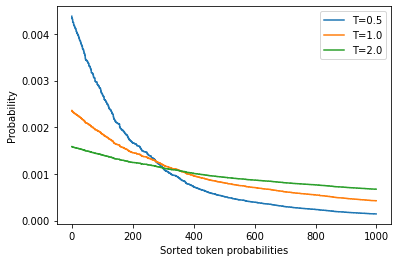

In [17]:
#hide_input

#id temperature
#alt Token probabilities as a function of temperature
#caption Distribution of randomly generated token probabilities for three selected temperatures
import matplotlib.pyplot as plt
import numpy as np

def softmax(logits, T=1):
    e_x = np.exp(logits / T)
    return e_x / e_x.sum()

logits = np.exp(np.random.random(1000))
sorted_logits = np.sort(logits)[::-1]
x = np.arange(1000)

for T in [0.5, 1.0, 2.0]:
    plt.step(x, softmax(sorted_logits, T), label=f"T={T}")
plt.legend(loc="best")
plt.xlabel("Sorted token probabilities")
plt.ylabel("Probability")
plt.show()

This code generates a plot that illustrates the distribution of randomly generated token probabilities for three selected temperatures (0.5, 1.0, 2.0) using the softmax function. The softmax function is used to convert a vector of real numbers (logits) to a probability distribution, which is useful for classification tasks. The plot shows how the probability distribution changes as the temperature (T) changes. A lower temperature results in a flatter distribution with less difference between the highest and lowest probabilities, while a higher temperature results in a steeper distribution with more difference between the highest and lowest probabilities. The x-axis represents the sorted token probabilities and the y-axis represents the probability.

In [18]:
# hide
torch.manual_seed(42);

In [19]:
output_temp = model.generate(input_ids, max_length=max_length, do_sample=True, 
                             temperature=2.0, top_k=0)
print(tokenizer.decode(output_temp[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


Banglington station 21 protagonist Breeboarding Chief Steve had storage goats invaded Speech spreading immune deficient laugh human massage irrational İvezin A jer Turner DorStatic errkg meremavern stall class inequariansiamond disse * Runew Endurance whilst spear secured conference be ankles coaching bees Zika MIA press Vatican credentials Wrestling chargesThings does Gu Buffer Ty physician Hidden Kimville66 Scotland Oz at affopy temporou MD sociology Canada iter


In [20]:
# hide
torch.manual_seed(42);

In [21]:
output_temp = model.generate(input_ids, max_length=max_length, do_sample=True, 
                             temperature=0.5, top_k=0)
print(tokenizer.decode(output_temp[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The researchers found that the unicorns, called "suspects," speak in a dialect that is similar to that of the Aryan language. The unicorns also had a higher IQ than the Aryan, which means they are more intelligent than the human race.


"This is a very interesting finding," said Tyndall Kim, a professor of linguistics at the University of California, Berkeley


## Top-k and Nucleus Sampling

In [22]:
# hide
torch.manual_seed(42);

In [23]:
# hide
input_txt = """In a shocking finding, scientist discovered \
a herd of unicorns living in a remote, previously unexplored \
valley, in the Andes Mountains. Even more surprising to the \
researchers was the fact that the unicorns spoke perfect English.\n\n
"""
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)

In [24]:
# hide
import torch.nn.functional as F

with torch.no_grad():
    output = model(input_ids=input_ids)
    next_token_logits = output.logits[:, -1, :]
    probs = F.softmax(next_token_logits, dim=-1).detach().cpu().numpy()

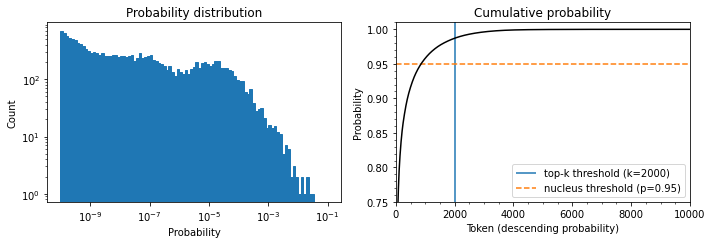

In [25]:
# hide_input

#id distribution
#alt Probability distribution of next token prediction.
#caption Probability distribution of next token prediction (left) and cumulative distribution of descending token probabilities

import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5))

axes[0].hist(probs[0], bins=np.logspace(-10, -1, 100), color="C0", edgecolor="C0")
axes[0].set_xscale("log")
axes[0].set_yscale("log")
axes[0].set_title("Probability distribution")
axes[0].set_xlabel("Probability")
axes[0].set_ylabel("Count")
#axes[0].grid(which="major")

axes[1].plot(np.cumsum(np.sort(probs[0])[::-1]), color="black")
axes[1].set_xlim([0, 10000])
axes[1].set_ylim([0.75, 1.01])
axes[1].set_title("Cumulative probability")
axes[1].set_ylabel("Probability")
axes[1].set_xlabel("Token (descending probability)")
#axes[1].grid(which="major")
axes[1].minorticks_on()
#axes[1].grid(which='minor', linewidth='0.5')
top_k_label = 'top-k threshold (k=2000)'
top_p_label = 'nucleus threshold (p=0.95)'
axes[1].vlines(x=2000, ymin=0, ymax=2, color='C0', label=top_k_label)
axes[1].hlines(y=0.95, xmin=0, xmax=10000, color='C1', label=top_p_label, linestyle='--')
axes[1].legend(loc='lower right')
plt.tight_layout()

This code generates a figure with two subplots that visualize the probability distribution of next token prediction based on the data in the variable probs. The first subplot is a histogram that shows the frequency of different probabilities in the data. The x-axis represents the probability, and the y-axis represents the count of tokens with that probability. The logarithmic scale is used for both the x-axis and y-axis to better visualize the distribution of less probable tokens. The second subplot is a line chart that shows the cumulative probability of the tokens in descending order of probability. The x-axis represents the token and the y-axis represents the cumulative probability. The plot has two vertical lines, one representing top-k threshold (k=2000) and another representing nucleus threshold (p=0.95), which are commonly used in fine-tuning GPT models. The top-k threshold is used to select the top-k tokens with the highest probabilities, while the nucleus threshold is used to select tokens with a cumulative probability of at least p. The idea is that the top-k threshold will select the most likely tokens, while the nucleus threshold will select a wider range of plausible tokens.

In [26]:
# hide
torch.manual_seed(42);

In [27]:
output_topk = model.generate(input_ids, max_length=max_length, do_sample=True, 
                             top_k=50)
print(tokenizer.decode(output_topk[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The scientists noted that the researchers did not find a single trace of an unusual combination of common human languages with the sounds described in this study, but this seems odd in such a remote area.


While the findings from the survey of 20,000 sheep and dogs had shown that no matter how loud or cold the animal's air was, it will often react at high altitudes to be in the region


In [28]:
# hide
torch.manual_seed(42);

In [29]:
output_topp = model.generate(input_ids, max_length=max_length, do_sample=True, 
                             top_p=0.90)
print(tokenizer.decode(output_topp[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The scientists found that the unicorns, called "suspects," speak English better than human languages, according to a report in the journal Evolution.


In the study, a group of researchers analyzed data from several types of research into human evolution from about 100 million years ago to about 10.5 million years ago. It's a new type of data, but the researchers think that in many respects


## Which Decoding Method Is Best?

## Conclusion